In [1]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import json
import glob

seed = 3 # debug!!!
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
if not os.path.exists('./previews'):
    os.makedirs('./previews')
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
n_row, n_col = 4, 7
n_words = n_row * n_col # 五言絕句
n_class = 0

In [3]:
def poet_filter(x):
    return len(''.join(x['paragraphs']))==n_words and len(''.join(x['strains']))==n_words # 五言絕句，不包含逗號句號分號

def poet_preprocess(x): # 去除標點符號
    x['paragraphs'] = ''.join(filter(lambda x: x!='，' and x!='。' and x!='；' ,list(''.join(x['paragraphs']))))
    x['strains'] = ''.join(filter(lambda x: x!='，' and x!='。' and x!='；' , list(''.join(x['strains']))))
    return x

def poet_data_reader(search='./chinese-poetry-master/json/poet.song.*.json', filters=lambda x: True):
    file_list = glob.glob(search)
    data = []
    for fname in file_list:
        with open(fname, 'r') as fp:
            data += filter(poet_filter, map(poet_preprocess , json.loads(fp.read())))
    return data
def gen_dict(poets):
    char_set = dict()
    char_set_inv = dict()
    for poet in poets:
        context = list(poet['paragraphs'])
        for c in filter(lambda x: x not in char_set, context):
            l = len(char_set)
            char_set[c] = l
            char_set_inv[l] = c
    return char_set, char_set_inv
def encode_context(context, charset):
    def f(x):
        return charset[x] if x in charset else 0
    return list(map(f, list(context)))
def one_hot(x, n_class):
    ohe = np.zeros((len(x), n_class), dtype=np.uint8)
    ohe[np.arange(len(x)), x] = 1
    return ohe
def str2ohe(x, charset):
    return one_hot(encode_context(x, charset), len(charset))
def ohe2str(x, charset_inv):
    x = np.argmax(x,axis=-1)
    return ''.join(list(map(lambda a: charset_inv[a], list(x))))

In [4]:
raw_data = poet_data_reader(search='./chinese-poetry-master/json/poet.song.*.json', filters=poet_filter)
charset, charset_inv = gen_dict(raw_data)
strainset = {'平': 0, '仄': 1}
strainset_inv = {0: '平', 1: '仄'}
with open('./charset.json', 'w') as fp:
    fp.write(json.dumps(charset))
with open('./strainset.json', 'w') as fp:
    fp.write(json.dumps(strainset))

In [5]:
class PoemDataset(torch.utils.data.Dataset):
    def __init__(self, raw_data, charset, strainset):
        super(PoemDataset, self).__init__()
        self.raw_data = raw_data
        self.charset = charset
        self.strainset = strainset
    def __len__(self):
        return len(self.raw_data)
    def __getitem__(self, index):
        x = torch.from_numpy(str2ohe(self.raw_data[index]['paragraphs'], self.charset).astype(np.float32).transpose(1,0)*2-1)
        y = torch.from_numpy(str2ohe(self.raw_data[index]['strains'], self.strainset).astype(np.float32).transpose(1,0)*2-1)
        return x, y

In [6]:
n_class = len(charset)
n_class

7902

In [7]:
poet_dataset = PoemDataset(raw_data, charset, strainset)
len(poet_dataset)

72900

In [8]:
data_loader = torch.utils.data.DataLoader(
        poet_dataset,
        batch_size=batch_size, shuffle=True, num_workers=2)
def inf_data_gen():
    while True:
        for data, label in data_loader:
            yield data, label
gen = inf_data_gen()

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0, 0.001)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.001)

class C(nn.Module):
    def __init__(self, n_words=20, n_class=5000):
        super(C, self).__init__()
        self.n_words = n_words
        self.n_class = n_class
        self.net = nn.Sequential(*[
            nn.Conv1d(self.n_class+2, 300, kernel_size=1, padding=0, bias=False), # embedding
            nn.Conv1d(300, 64, kernel_size=3, stride=1, padding=1, bias=False), # 10
            nn.InstanceNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2, bias=False), # 10
            nn.InstanceNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1, bias=False), # 10
            nn.InstanceNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1, bias=False), # 10
            nn.InstanceNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1, bias=False), # 5
            nn.InstanceNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Conv1d(512, 1, kernel_size=n_words//4, padding=0, bias=False)
        ])
        self.net.apply(weights_init)
        
    def forward(self, x, label):
        x = torch.cat((x, label), 1)
        x = self.net(x)
        x = x.view(x.size(0),1)
        return x

class G(nn.Module):
    def __init__(self, n_words=20, n_class=5000):
        super(G, self).__init__()
        self.n_words = n_words
        self.n_class = n_class
        
        self.conv1 = nn.Conv1d(2, 64, kernel_size=3, stride=1, padding=1, bias=False) # 20
        self.norm1 = nn.InstanceNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2, bias=False) # 10
        self.norm2 = nn.InstanceNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1, bias=False) # 10
        self.norm3 = nn.InstanceNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1, bias=False) # 5
        self.norm4 = nn.InstanceNorm1d(512)
        self.upconv5 = nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1, bias=False) # 10
        self.norm5 = nn.InstanceNorm1d(256+256)
        self.upconv6 = nn.ConvTranspose1d(256+256, 300, kernel_size=4, stride=2, padding=1, bias=False) # 20
        self.norm6 = nn.InstanceNorm1d(300+64)
        self.conv7 = nn.Conv1d(300+64, self.n_class, kernel_size=1, stride=1, padding=0, bias=False) # 20
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.1)
        x = F.dropout(x, 0.5)
        s1 = x
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x, 0.1)
        x = F.dropout(x, 0.5)
        
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, 0.1) # 10
        s2 = x
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x, 0.1) # 5
        
        x = self.upconv5(x)
        x = torch.cat((x, s2), 1)
        x = self.norm5(x)
        x = F.leaky_relu(x, 0.1) # 10
        
        x = self.upconv6(x)
        x = torch.cat((x, s1), 1)
        x = self.norm6(x)
        x = F.leaky_relu(x, 0.1) # 20
        
        x = self.conv7(x) # 20
        x = torch.tanh(x)
        return x


In [10]:
G_net = G(n_words, n_class).to(device).apply(weights_init)
C_net = C(n_words, n_class).to(device)
opt_C = optim.Adam(C_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

<IPython.core.display.Javascript object>


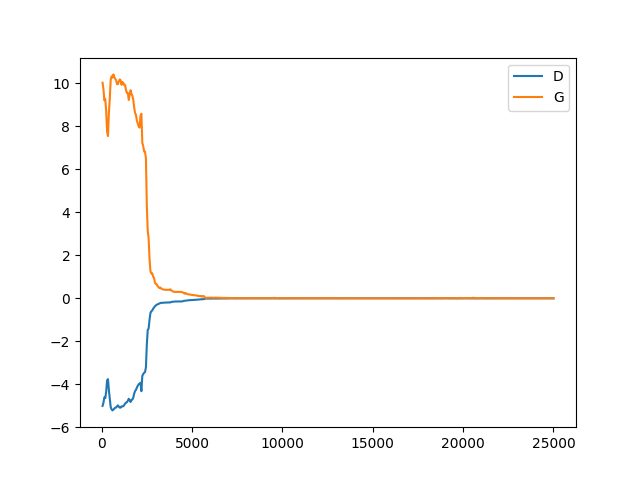

KeyboardInterrupt: 

In [11]:
from tqdm import tqdm_notebook

iterations = 50000
preview_iter = 500
plot_iter = 50
preview_n = 8
d_iter = 2
std = 1.0
k, p = 2, 6
beta = 0.001

ites = []
G_list = []
D_list = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

tqdm_ite = tqdm_notebook(range(1, iterations+1))

for ite in tqdm_ite:
    # train D:
    G_net.train() # enable dropout
    C_net.train()
    d_loss_mean = 0.0
    g_loss_mean = 0.0
    for _ in range(d_iter):
        opt_C.zero_grad()
        real, label = next(gen)
        real = real.to(device)
        label = label.to(device)
        with torch.no_grad():
            fake   = G_net(label).detach() # not to touch G_net
        d_real = C_net(real,label)
        d_fake = C_net(fake,label)
        
        d_loss = d_real - d_fake
        d_norm = 10 * (real - fake).abs().mean()
        d_loss = -d_loss + 0.5 * d_loss**2 / d_norm
        d_loss = d_loss.mean()
        d_loss.backward()
        
        opt_C.step()
        d_loss_mean += d_loss.item()
    d_loss_mean /= d_iter
    # train G:
    G_net.train()
    C_net.eval() 
    real, label = next(gen)
    real = real.to(device)
    label = label.to(device)
    opt_G.zero_grad()
    generated = G_net(label)
    g_loss = (C_net(real,label) - C_net(generated,label)).mean() + beta * torch.abs(real-generated).mean()
    g_loss.backward()
    opt_G.step()
    g_loss_mean = g_loss.mean().item()
    if ite%plot_iter==0:
        tqdm_ite.set_description('G:{:.4f}, D:{:.4f}'.format(g_loss_mean, d_loss_mean))
        tqdm_ite.refresh()
        D_list.append(d_loss_mean)
        G_list.append(g_loss_mean)
        ites.append(ite)
        ax.clear()
        ax.plot(ites, D_list)
        ax.plot(ites, G_list)
        ax.legend(['D','G'], loc='upper right')
        fig.canvas.draw()
    if ite%preview_iter==0:
        label = label[:preview_n].detach().cpu().numpy().transpose(0,2,1)
        generated = generated[:preview_n].detach().cpu().numpy().transpose(0,2,1)
        label = list(map(lambda x: ohe2str(x, strainset_inv), label))
        generated = list(map(lambda x: ohe2str(x, charset_inv), generated))
        with open('./previews/iter-{:d}.txt'.format(ite), 'w') as fp:
            for l, poet in zip(label,generated):
                for r in range(n_row):
                    fp.write(poet[ (r*n_col):((r+1)*n_col) ] + ('，' if r%2==0 else '。'))
                fp.write('\n')
                for r in range(n_row):
                    fp.write(l[ (r*n_col):((r+1)*n_col) ] + ('，' if r%2==0 else '。'))
                fp.write('\n')
        
        torch.save(G_net.state_dict(), './checkpoints/iter-{:d}-G.ckpt'.format(ite))
        torch.save(C_net.state_dict(), './checkpoints/iter-{:d}-D.ckpt'.format(ite))